## Imports

In [1]:
import os
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import color

import numpy as np
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda:0")

## Dataset

In [3]:
!wget http://sereja.me/f/universum_compressed.tar
!tar xf universum_compressed.tar
!rm -rf sample_data

--2022-03-31 20:07:14--  http://sereja.me/f/universum_compressed.tar
Resolving sereja.me (sereja.me)... 213.159.215.132
Connecting to sereja.me (sereja.me)|213.159.215.132|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 72028160 (69M) [application/x-tar]
Saving to: ‘universum_compressed.tar’

universum_compresse 100%[===================>]  68.69M  7.62MB/s    in 15s     

2022-03-31 20:07:29 (4.73 MB/s) - ‘universum_compressed.tar’ saved [72028160/72028160]



In [4]:
from google.colab import drive

drive.mount("gdrive")

Mounted at gdrive


In [5]:
%cd gdrive/MyDrive/Models

/content/gdrive/MyDrive/Models


## Dataset, DataLoader

In [6]:
class ColorizationDataset(Dataset):
    def __init__(self, path, transform_x, transform_y):
        self.transform_x = transform_x
        self.transform_y = transform_y
      
        filenames = []
        for root, dirs, files in os.walk(path):
            for file in files:
                if file.endswith('.jpg') or file.endswith('.JPG'):
                    filenames.append(os.path.join(root, file))

        self.images = []
        for filename in tqdm(filenames):
            try:
                with Image.open(filename) as image:
                    self.images.append(image.copy())
            except:
                pass


    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        Y = self.transform_y(img)
        X = self.transform_x(Y)
        return X, Y



In [7]:
def normalize_lab(lab):
    lab[:, :, 0] = (lab[:, :, 0] - 50.0) / 100.0
    lab[:, :, 1:] /= 110.0

    return lab

def unnormalize_l(img_l):
    return (img_l * 100.0) + 50.0

def unnormalize_ab(img_ab):
    return img_ab * 110.0

def unnormalize_lab(img_lab, target=False):
    if target:
        img_lab[0, :, :] = (img_lab[0, :, :] * 100.0) + 50.0
        img_lab[1:, :, :] = img_lab[1:, :, :] * 110.0

    else:
        img_lab[:, 0, :, :] = (img_lab[:, 0, :, :] * 100.0) + 50.0
        img_lab[:, 1:, :, :] = img_lab[:, 1:, :, :] * 110.0

    return img_lab


In [8]:
def to_l(x):
    x_l = x[0, :, :].clone()
    return x_l.view(1, 128, 128)

def rgb2lab(img):
    lab_img = color.rgb2lab(img)
    return normalize_lab(lab_img)

all_transforms = transforms.Compose([
    transforms.RandomResizedCrop(size=(128, 128)),
    transforms.RandomHorizontalFlip(p=0.4),
    # transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 1.5)),
    # transforms.RandomPerspective(distortion_scale=0.2, p=0.6),
    # transforms.RandomRotation(degrees=(0, 30)),
    transforms.Lambda(rgb2lab),
    transforms.ToTensor(),
])


In [9]:
def to_numpy_image(img):

    return img.detach().cpu().view(3, 128, 128).transpose(0, 1).transpose(1, 2).numpy()

def show_img(low_idx, high_idx):
    for t in range(low_idx, high_idx):
        img_gray, img_true = dataset[t]
        img_pred = model(img_gray.to(device).float().view(1, 1, 128, 128))

        img_gray = unnormalize_l(img_gray)
        img_pred = unnormalize_lab(img_pred)
        img_true = unnormalize_lab(img_true, target=True)

        img_pred = to_numpy_image(img_pred)
        img_true = to_numpy_image(img_true)

        img_pred = color.lab2rgb(img_pred)
        img_true = color.lab2rgb(img_true)

        plt.figure(figsize=(10,10))
      
        plt.subplot(141)
        plt.axis('off')
        plt.set_cmap('Greys')
        plt.imshow(img_gray.reshape((128, 128)))

        plt.subplot(142)
        plt.axis('off')
        plt.imshow(img_pred)

        plt.subplot(143)
        plt.axis('off')
        plt.imshow(img_true)
        
        plt.show()

In [10]:
dataset = ColorizationDataset("/content/universum-photos", to_l, all_transforms)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

100%|██████████| 1254/1254 [00:02<00:00, 463.66it/s]


## Convolution Network

In [11]:
class Colorizer(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layers = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=2, padding=1),       # 64x64
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),       # 32x32
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),       # 16х16
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1),       
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Upsample(scale_factor=2),                                                            # 32x32
            nn.Conv2d(in_channels=256, out_channels=313, kernel_size=3, stride=1, padding=1), 
            nn.Softmax(dim=1),
            nn.Conv2d(in_channels=313, out_channels=2, kernel_size=3, stride=1, padding=1),
            nn.Upsample(scale_factor=4),                                                            # 2x128x128

        )

    def forward(self, x):
        ab_layers = self.layers(x)
        res_lab = torch.cat((x, ab_layers), dim=1)
        return res_lab


In [12]:
epochs = 2000
learning_rate = 1e-3

model = Colorizer().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction="mean")

In [13]:
model.load_state_dict(torch.load("weights_model_210.pt"))

<All keys matched successfully>

In [ ]:
history = []

for epoch in tqdm(range(epochs)):
    for x, y in loader:
        x = x.to(device).float()
        y = y.to(device).float()

        optimizer.zero_grad()

        pred = model(x)
        loss = criterion(y, pred)
        history.append(loss.item())

        loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"weights_model_{epoch}.pt")
        print(f"epoch: {epoch}, loss: {history[-1]}")
        show_img(110, 115)

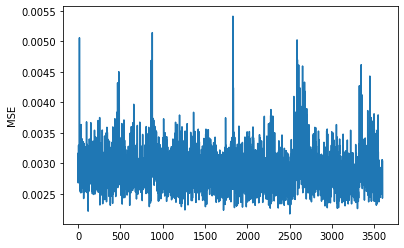

In [15]:
plt.plot(history)
plt.ylabel("MSE")
plt.show()

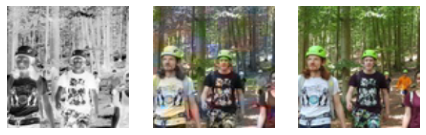

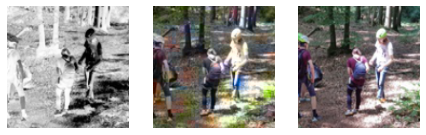

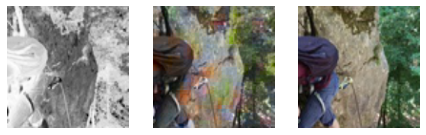

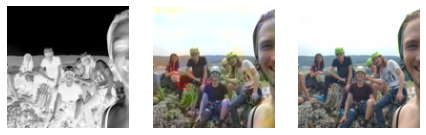

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1109: UserWarning: Color data out of range: Z < 0 in 15 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


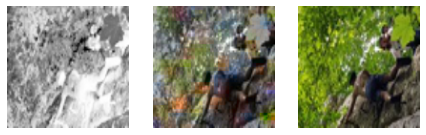

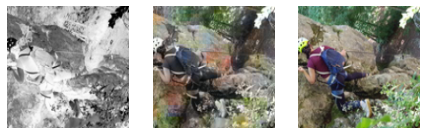

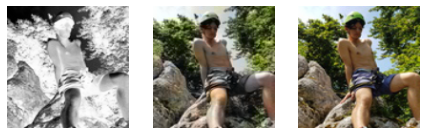

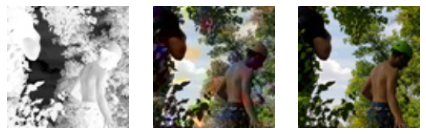

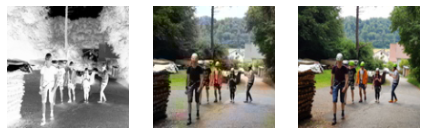

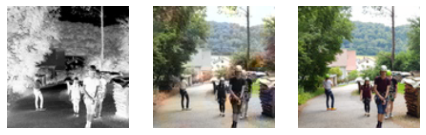

In [16]:
show_img(400, 410)